In [1]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import h5py
import numpy as np
import os
import glob
import pandas as pd
import scipy.stats as st
import sunpy.coordinates.sun as sn
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from palettable.colorbrewer.qualitative import Dark2_5, Set1_3

import huxt as H
import huxt_analysis as HA
import huxt_inputs as HIN
import GeoModelUncertainty as gmu

In [73]:
def get_los(ro, lo, el):
    """
    Function to compute a matplotlib patch to higlight an observers field of view. 
    ro = radius of observer (in solRad)
    lo = longitude of observer (in rad)
    el_min = minimum elongation of the field of view
    el_max = maximum elongation of the field of view
    """
    xo = ro*np.cos(lo)
    yo = ro*np.sin(lo)
            
    rp = ro*np.tan(el)
    if (lo < 0*u.rad) | (lo > np.pi*u.rad):
        lp = lo + 90*u.deg
    else:
        lp = lo - 90*u.deg

    if lp > 2*np.pi*u.rad:
        lp = lp - 2*np.pi*u.rad

    xp = rp*np.cos(lp)
    yp = rp*np.sin(lp)

    # Wolfram equations for intersection of line with circle
    rf = 475*u.solRad  # set this to a large value outside axis lims so FOV shading spans model domain
    dx = (xp - xo)
    dy = (yp - yo)
    dr = np.sqrt(dx**2 + dy**2)
    det = (xo*yp - xp*yo)
    discrim = np.sqrt((rf*dr)**2 - det**2)

    if (lo < 0*u.rad) | (lo > np.pi*u.rad):
        xf = (det*dy + np.sign(dy)*dx*discrim) / (dr**2)
        yf = (-det*dx + np.abs(dy)*discrim) / (dr**2)
    else:
        xf = (det*dy - np.sign(dy)*dx*discrim) / (dr**2)
        yf = (-det*dx - np.abs(dy)*discrim) / (dr**2)

    lf = np.arctan2(yf, xf)
    
    return lf, rf


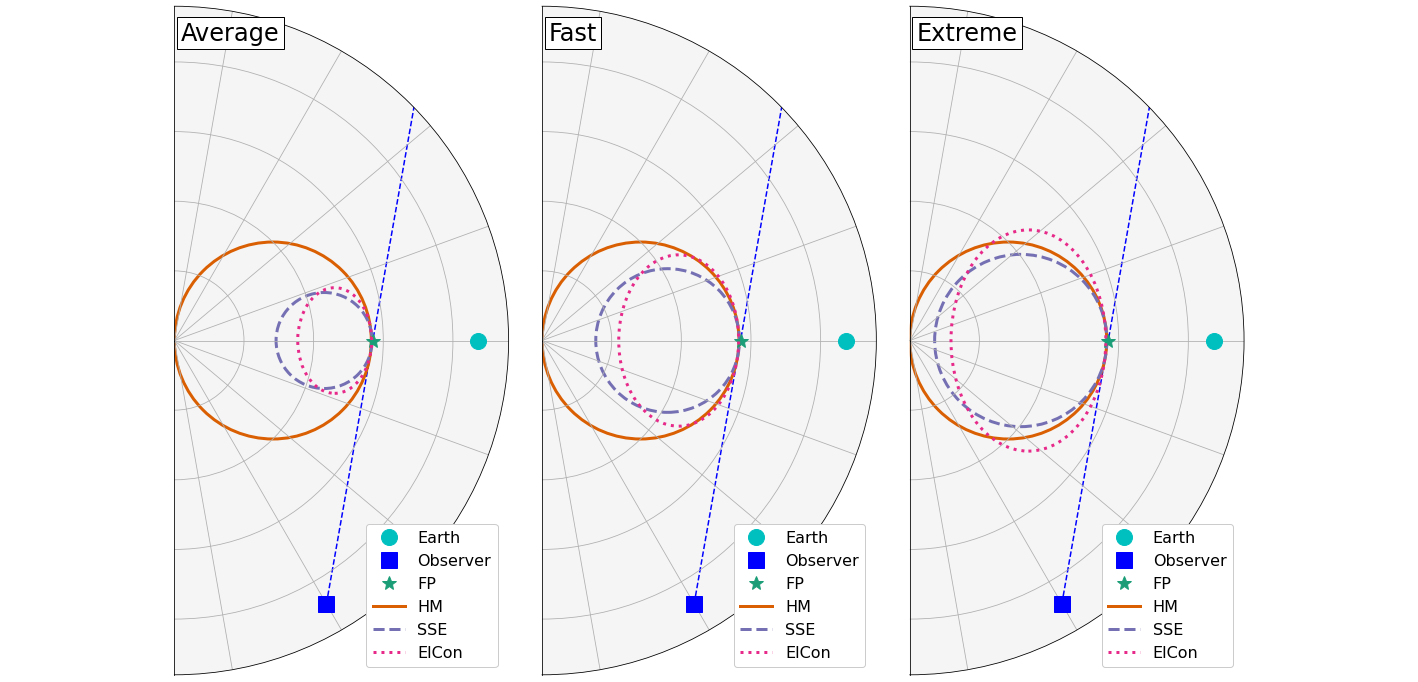

In [98]:
cme_scenarios = gmu.load_cme_scenarios()

gm_keys = ['fp', 'hm', 'sse', 'elp']
gm_cols = {gk:Dark2_5.mpl_colors[i] for i, gk in enumerate(gm_keys)}
gm_style = {'fp':'*', 'hm':'-', 'sse':'--', 'elp':':' }
    
fig, ax = plt.subplots(1, 3, figsize=(15, 10), subplot_kw={"projection": "polar"})

for i, scenario_key in enumerate(['average', 'fast', 'extreme']):
    scenario = cme_scenarios[scenario_key]
    
    
    start_time = Time('2008-06-10T00:00:00')

    ert = H.Observer('EARTH', start_time)
    lons, dlon, nlon = H.longitude_grid()
    vr_in = 400*(u.km/u.s)*np.ones(lons.size)
    cr_num = np.fix(sn.carrington_rotation_number(start_time))

    model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
                   lon_start=300*u.deg, lon_stop=60*u.deg, simtime=5*u.day, dt_scale=1)

    t_launch = (1*u.hr).to(u.s)
    cme = H.ConeCME(t_launch=t_launch, longitude=0*u.deg, latitude=model.latitude.to(u.deg),
                    width=scenario['width'], v=scenario['speed'], thickness=0.1*u.solRad)

    model.solve([cme])
    cme = model.cmes[0]

    # Observe the CME from L4 and L5
    observer = gmu.Observer(model, 300.0*u.deg, el_min=4.0, el_max=60.0, color='b', name='L5')

    # Add on CME boundaries and Observer
    ert = model.get_observer('EARTH')
    ax[i].plot(ert.lon[0], ert.r[0], 'co', markersize=16, label='Earth')            
    ax[i].plot(observer.lon[0], observer.r[0], 's', color=observer.color, markersize=16, label='Observer')

    ######################
    # Add on the geometric models
    r_obs = observer.r[0]
    lon_obs = observer.lon[0]
    el = np.deg2rad(40)*u.rad
    lf, rf = get_los(r_obs, lon_obs, el)
    
    ax[i].plot([lon_obs.value, lf.value], [r_obs.value, rf.value], '--', color=observer.color, zorder=0)

    #Fixed Phi
    lon_apex, r_apex = gmu.fixed_phi(cme, r_obs, lon_obs, el)
    ax[i].plot(lon_apex.value, r_apex.value, '*', markersize=14, color=gm_cols['fp'])

    # Harmonic mean
    lon_apex, r_apex, r_center, radius = gmu.harmonic_mean(cme, r_obs, lon_obs, el)
    x_c = r_center*np.cos(lon_apex)
    y_c = r_center*np.sin(lon_apex)
    hmm_circ = plt.Circle((x_c.value, y_c.value), radius.value, color=gm_cols['hm'], fill=False, linewidth=3, linestyle=gm_style['hm'], zorder=0, transform=ax[i].transData._b)
    ax[i].add_artist(hmm_circ)

    # Self similar expansion
    lon_apex, r_apex, r_center, radius = gmu.self_similar_expansion(cme, r_obs, lon_obs, el)
    x_c = (r_center*np.cos(lon_apex)).value
    y_c = (r_center*np.sin(lon_apex)).value
    sse_circ = plt.Circle((x_c, y_c), radius.value, color=gm_cols['sse'], fill=False, linewidth=3, linestyle=gm_style['sse'], zorder=1, transform=ax[i].transData._b)
    ax[i].add_artist(sse_circ)

    # Elcon
    lon_apex, r_apex, r_center, r_a, r_b = gmu.elcon(cme, r_obs, lon_obs, el)
    x_c = (r_center*np.cos(lon_apex)).value
    y_c = (r_center*np.sin(lon_apex)).value
    l_c = cme.longitude.value
    elp_elip = mpl.patches.Ellipse(xy=[x_c, y_c], width=2*r_b.value, height=2*r_a.value, angle=l_c, color=gm_cols['elp'], fill=False,
                                   linewidth=3, linestyle=gm_style['elp'], zorder=2, transform=ax[i].transData._b)
    ax[i].add_artist(elp_elip)

for a in ax:
    a.set_xlim(-np.pi/2, np.pi/2)
    a.set_ylim(0, 240)
    a.set_yticklabels([])
    a.set_xticklabels([])
    a.patch.set_facecolor('whitesmoke')
    
    a.plot([], [], gm_style['fp'], markersize=14, color=gm_cols['fp'], label='FP')
    a.plot([], [], linestyle=gm_style['hm'], color=gm_cols['hm'], linewidth=3, label='HM')
    a.plot([], [], linestyle=gm_style['sse'], color=gm_cols['sse'], linewidth=3, label='SSE')
    a.plot([], [], linestyle=gm_style['elp'], color=gm_cols['elp'], linewidth=3, label='ElCon')

    a.legend(loc='lower left', bbox_to_anchor=(0.525, 0.0), framealpha=1.0)
    
for a, lab in zip(ax, ['Average', 'Fast', 'Extreme']):
            a.text(0.26, 0.95, lab, horizontalalignment='left', transform=a.transAxes, fontsize=24 ,bbox=dict(facecolor='white'))


fig.subplots_adjust(left=-0.15, bottom=-0.0, right=1.15, top=0.99, wspace=-0.45)
fig.savefig('geomodel_schematic.pdf', format='pdf')